# API BASICS

In [4]:
from pySubnetSB.api import ModelSpecification, findReferenceInTarget, clusterStructurallyIdenticalModelsInDirectory,  \
        findReferencesInTargets, makeSerializationFile

import numpy as np
import pandas as pd
import tellurium as te

# Simple Usage

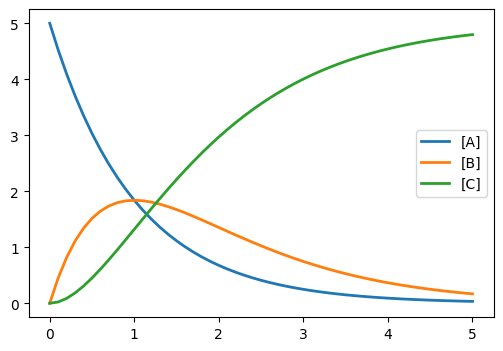

In [6]:
reference_model = """
A -> B; k1*A
B -> C; k2*B

A = 5
B = 0
k1 = 1
k2 = 1
"""
rr = te.loada(reference_model)
rr.simulate()
rr.plot()

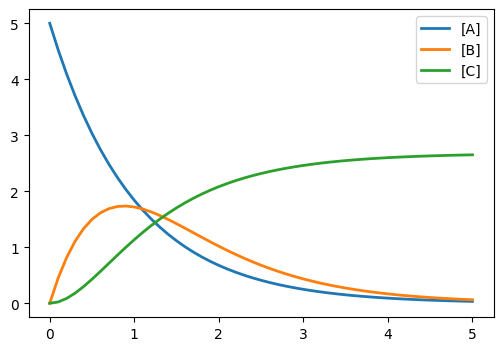

In [8]:
target_model = """
A -> B; k1*A
B -> C; k2*B
B + C -> ; k3*B*C

A = 5
B = 0
k1 = 1
k2 = 1
k3 = 0.2
"""
rr = te.loada(target_model)
rr.simulate()
rr.plot()

In [9]:
result = findReferenceInTarget(reference_model, target_model)


ssignments: 100%|███████████| 8333330/8333330 [00:00<00:00, 32788479692.61it/s]

In [10]:
result

StructurallyIdenticalResult(assignment_pairs=[species: [0 1 2], reaction: [0 1]]; is_truncated=False;

In [12]:
result.assignment_pairs

[species: [0 1 2], reaction: [0 1]]